# Data 


In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
from sklearn.model_selection import train_test_split

# ---------- File Loading ---------- #
#uploaded = files.upload()
link = 'https://raw.githubusercontent.com/stepmolotov/ML-CUP-2019/master/ML-CUP19-TR.csv'
data = pd.read_csv(link, skiprows=7, header=None)
# data.shape[0], data.shape[1]
data.drop(axis=1, columns=0, inplace=True)

Using TensorFlow backend.


In [0]:
target = data[data.columns[-2:]]
target.columns = ['x', 'y']

X = data[data.columns[:-2]]
y = target

X = X.values
y = y.values

# Keras NN

In [0]:
# Gets the best models out of the grid search results
def report(results, n_top=3, metric='loss'):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_'+metric] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("(loss) Mean validation score: {0:.4f} (std: {1:.4f})".format(
                  -1*results['mean_test_loss'][candidate],
                  results['std_test_loss'][candidate]))
            print("(mee) Mean validation score: {0:.4f} (std: {1:.4f})".format(
                  results['mean_test_mee'][candidate],
                  results['std_test_mee'][candidate]))
            print("--- Parameters: {0}".format(results['params'][candidate]))
            print("")

from sklearn.metrics import make_scorer

def mean_euclidean_error(X, Y):
    sum = 0
    for x, y in zip(X, Y):
        sum += np.linalg.norm(x - y, ord=2)
    return sum / X.shape[0]

#scoring = {'loss': 'neg_mean_squared_error', 'mee': make_scorer(mean_euclidean_error)}
scores = {'loss': 'neg_mean_squared_error', 'mee': make_scorer(mean_euclidean_error)}

In [0]:
# from sklearn.preprocessing import RobustScaler
# X = RobustScaler().fit_transform(X)
# y = RobustScaler().fit_transform(y)

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=1)

In [0]:
from keras.regularizers import l2
from keras.constraints import maxnorm
# define the keras model
def create_model(batch_size=32, units=[100, 200, 100], lr=0.01, momentum=0.9, 
                 nesterov=True, decay=1e-6, dropout=0, reg=0):
  model = Sequential()

  layers = len(units)
  for layer in range(0,layers):
    if layer == 0: # first layer needs input size
      model.add(Dense(units[layer], kernel_initializer='normal', kernel_constraint=maxnorm(3), input_dim=20, activation='relu', kernel_regularizer=l2(reg), bias_regularizer=l2(reg)))
    else:
      model.add(Dense(units[layer], activation='relu', kernel_regularizer=l2(reg), bias_regularizer=l2(reg)))
    if dropout > 0:
        model.add(Dropout(dropout))
  model.add(Dense(2, activation='linear', kernel_regularizer=l2(reg), bias_regularizer=l2(reg)))

  opt = SGD(lr=lr, momentum=momentum, clipnorm=1, decay=decay, nesterov=nesterov)
  model.compile(loss='mean_squared_error', optimizer=opt)
  # model.compile(optimizer='rmsprop', loss='mse')

  return model

# Grid Params
param_list = {
              'batch_size': [4, 8, 16, 32, 64],
              'lr': [0.01, 0.025, 0.05],
              'momentum': [0.85, 0.9, 0.95],
              'nesterov': [True] 
             }

smooth_params_list = {
              'batch_size': [64],
              'lr': [0.001],
              'momentum': [0.9],
              'decay': [1e-3],
              'nesterov': [False]
             }

perform_params_list = {
              'batch_size': [64],
              'lr': [0.1],
              'momentum': [0.9],
              'decay': [1e-3],
              'nesterov': [False],
              'dropout': [0.2]
             }

In [0]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

start = time.time()
n_epochs = 500
regressor = KerasRegressor(build_fn=create_model, verbose=1, epochs=n_epochs)
grid = GridSearchCV(estimator=regressor, param_grid=perform_params_list, scoring=scores, verbose=1, n_jobs=4, cv=10, refit=False, return_train_score=True)
grid_result = grid.fit(train_X, train_y)

# summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

end = time.time()
print('Fit time: ' + str(end - start))

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fit time: 213.0425260066986


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:  3.6min finished


In [0]:
report(grid_result.cv_results_, n_top=1) # I only did the grid on 1 combination, to get the scores

Model with rank: 1
(loss) Mean validation score: 0.8950 (std: 0.1387)
(mee) Mean validation score: 0.9801 (std: 0.0610)
--- Parameters: {'batch_size': 64, 'decay': 0.001, 'dropout': 0.2, 'lr': 0.1, 'momentum': 0.9, 'nesterov': False}



In [0]:
grid_txt = pd.read_csv('mlp_grid.txt', skiprows=1, header=None)

## Best Model

In [0]:
# good learning curve
# best_mlp = create_model(batch_size=train_X.shape[0], units=[100, 200, 100], lr=0.01, momentum=0.9, nesterov=False, decay=1e-9, dropout=0.1, reg=0.0001)

# smooth
best_mlp = create_model(batch_size=64, units=[100, 200, 100], lr=0.001, momentum=0.9, nesterov=False, decay=1e-3)

#best_mlp = create_model(batch_size=train_X.shape[0], units=[100, 200, 300, 200, 100], lr=0.0001, momentum=0.9, nesterov=False, decay=1e-9, dropout=0, reg=0.0001)

n_epochs = 2000
start = time.time()
best_mlp.fit(train_X, train_y, epochs=n_epochs, validation_split=0.1, verbose=2, scoring)
end = time.time()
print('MLP time: ' + str(end - start))


Train on 1270 samples, validate on 142 samples
Epoch 1/2000
 - 2s - loss: 221.0556 - val_loss: 209.2570
Epoch 2/2000
 - 0s - loss: 207.0816 - val_loss: 193.1287
Epoch 3/2000
 - 0s - loss: 186.9698 - val_loss: 169.0161
Epoch 4/2000
 - 0s - loss: 156.9631 - val_loss: 135.5555
Epoch 5/2000
 - 0s - loss: 119.8297 - val_loss: 95.4834
Epoch 6/2000
 - 0s - loss: 78.8428 - val_loss: 58.0377
Epoch 7/2000
 - 0s - loss: 47.8530 - val_loss: 37.6072
Epoch 8/2000
 - 0s - loss: 34.6451 - val_loss: 28.5584
Epoch 9/2000
 - 0s - loss: 26.1797 - val_loss: 21.7788
Epoch 10/2000
 - 0s - loss: 19.8016 - val_loss: 16.6873
Epoch 11/2000
 - 0s - loss: 14.8272 - val_loss: 12.9385
Epoch 12/2000
 - 0s - loss: 11.3806 - val_loss: 10.8154
Epoch 13/2000
 - 0s - loss: 9.4173 - val_loss: 9.6377
Epoch 14/2000
 - 0s - loss: 8.2492 - val_loss: 8.8136
Epoch 15/2000
 - 0s - loss: 7.4975 - val_loss: 8.1607
Epoch 16/2000
 - 0s - loss: 6.8788 - val_loss: 7.5635
Epoch 17/2000
 - 0s - loss: 6.3998 - val_loss: 7.0254
Epoch 18/20

Train: 1.0437, Validation: 1.1589


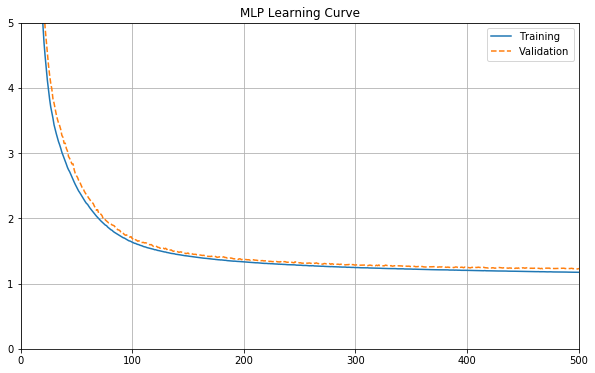

In [0]:
# evaluate the model
history = best_mlp.history.history
print('Train: %.4f, Validation: %.4f' % (history['loss'][n_epochs-1], history['val_loss'][n_epochs-1]))
# plot loss during training
plt.figure(figsize=(10,6))#da rivedere
plt.title('MLP Learning Curve')
plt.plot(history['loss'], label='Training')
plt.plot(history['val_loss'], label='Validation', ls='--')
plt.legend()
plt.xlim(0,500)
plt.ylim(0,5)
plt.grid()
plt.show()

In [0]:
history.keys()

dict_keys(['val_loss', 'loss'])

In [0]:
y_pred = best_mlp.predict(test_X)
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test_y, y_pred)
print('Test LOSS : ' + str(mse))
mee = mean_euclidean_error(test_y, y_pred)
print('Test MEE : ' + str(mee))

LOSS : 1.318589970713452
MEE : 1.2449168023520962


Text(26, -14.5, 'MEE: 1.2449')

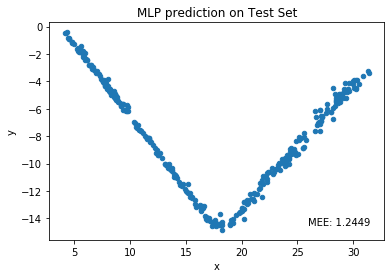

In [0]:
# MLP V on our test_X
y_pred = best_mlp.predict(test_X)
y_pred = pd.DataFrame(y_pred, columns=['x', 'y'])

y_pred.plot(kind='scatter', x='x', y='y')
plt.title('MLP prediction on Test Set')
plt.text(26,-14.5, 'MEE: %.4f' % (mee))
# y_pred.head()

## Perfoming Model

In [0]:
# smooth
best_mlp_perf = create_model(batch_size=64, units=[100, 200, 100], lr=0.1, momentum=0.9, nesterov=False, decay=1e-3, dropout=0.2)

n_epochs = 500
start = time.time()
best_mlp_perf.fit(train_X, train_y, epochs=n_epochs, validation_split=0.1, verbose=2)
end = time.time()
print('MLP time: ' + str(end - start))


Train on 1270 samples, validate on 142 samples
Epoch 1/500
 - 1s - loss: 141.0097 - val_loss: 15.1731
Epoch 2/500
 - 0s - loss: 10.8134 - val_loss: 4.3412
Epoch 3/500
 - 0s - loss: 7.5634 - val_loss: 3.2007
Epoch 4/500
 - 0s - loss: 5.0453 - val_loss: 3.2614
Epoch 5/500
 - 0s - loss: 4.6832 - val_loss: 2.0204
Epoch 6/500
 - 0s - loss: 4.0283 - val_loss: 3.3350
Epoch 7/500
 - 0s - loss: 3.7690 - val_loss: 2.6814
Epoch 8/500
 - 0s - loss: 3.5254 - val_loss: 1.9452
Epoch 9/500
 - 0s - loss: 3.3159 - val_loss: 1.8433
Epoch 10/500
 - 0s - loss: 3.5388 - val_loss: 1.8628
Epoch 11/500
 - 0s - loss: 3.2072 - val_loss: 2.0640
Epoch 12/500
 - 0s - loss: 2.8713 - val_loss: 2.0229
Epoch 13/500
 - 0s - loss: 2.9691 - val_loss: 1.7761
Epoch 14/500
 - 0s - loss: 2.7790 - val_loss: 1.8142
Epoch 15/500
 - 0s - loss: 2.7467 - val_loss: 2.0763
Epoch 16/500
 - 0s - loss: 2.6552 - val_loss: 1.4925
Epoch 17/500
 - 0s - loss: 2.5352 - val_loss: 1.3688
Epoch 18/500
 - 0s - loss: 2.3955 - val_loss: 1.8060
Epoc

Train: 0.7887, Validation: 0.9210


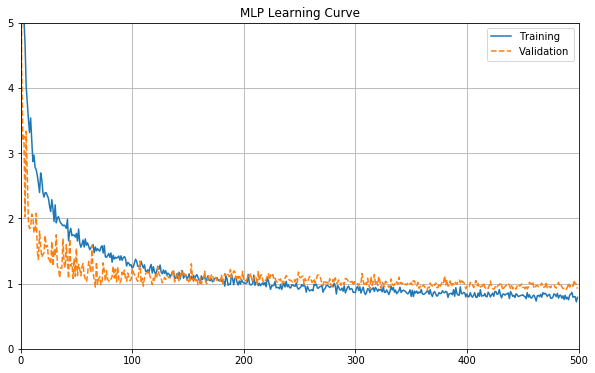

In [0]:
# evaluate the model
history = best_mlp_perf.history.history
print('Train: %.4f, Validation: %.4f' % (history['loss'][n_epochs-1], history['val_loss'][n_epochs-1]))
# plot loss during training
plt.figure(figsize=(10,6))#da rivedere
plt.title('MLP Learning Curve')
plt.plot(history['loss'], label='Training')
plt.plot(history['val_loss'], label='Validation', ls='--')
plt.legend()
plt.xlim(0,500)
plt.ylim(0,5)
plt.grid()
plt.show()